In [1]:
########################################
# Packages
########################################
import warnings
import h5py as h5
import numpy as np
import pandas as pd
import multiprocessing as mp

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import math

import statistics

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.stats import binned_statistic
import scipy.stats.distributions as dist

import seaborn as sns

In [2]:
from data_processing import SHARKDataProcessor
processor = SHARKDataProcessor()

# Define subvolume IDs and HDF5 file paths
sv_list = np.arange(64)
sharkfiles = [f'extracted_data_z=0/199/{sv}/galaxies.hdf5' for sv in sv_list] #DEFINE FILE

# Output shark_csv dataframe
shark_csv = processor.process_all_subvolumes(sv_list, sharkfiles)
print(shark_csv.head())

  ID_galaxy ID_subhalo    ID_subhalo_tree ID_halo  sv  type    Mhalo_host  \
0   0_12323        0_1  0_199000000000184     0_1   0     0  1.553645e+12   
1   0_41884        0_2  0_199000000032613     0_1   0     1  1.553645e+12   
2   0_25337        0_4  0_199000000000239     0_2   0     0  1.013176e+12   
3   0_12324        0_4  0_199000000000239     0_2   0     2  1.013176e+12   
4  0_325815        0_5  0_199000000032723     0_2   0     1  1.013176e+12   

          Mhalo   Mstar_bulge    Mstar_disc  ...  SFR_bulge  SFR_disc  \
0  1.406334e+12  4.406725e+10  8.090279e+09  ...   0.239161  8.448190   
1  1.132662e+11  6.663850e+07  3.927870e+08  ...   0.000000  0.045958   
2  7.889350e+11  1.441911e+10  7.342129e+06  ...   5.469577  0.054259   
3  4.321138e+10  4.237961e+08  9.966004e+08  ...   0.000000  0.128186   
4  2.242409e+11  4.860634e+08  7.437644e+08  ...   0.000000  0.316807   

    SFR_all           MBH  MBHacc_cold    MBHacc_hot    MBHacc_all  \
0  8.687351  2.992633e+07   

In [26]:
print(data['SFR_all'].describe())  # Before applying threshold

print(shark_csv['SFR_all'].describe())  # Before applying threshold


count    221646.000000
mean          0.179641
std          10.366333
min           0.001585
25%           0.001585
50%           0.001585
75%           0.004089
max        4448.072630
Name: SFR_all, dtype: float64
count    928625.000000
mean          0.707455
std          12.953442
min           0.001585
25%           0.004692
50%           0.025104
75%           0.137019
max        4448.072630
Name: SFR_all, dtype: float64


In [3]:
########################################
# gal_sv settings
########################################
# type: galaxy type; =0 for centrals; =1 for satellites that reside in well identified subhalos; =2 for orphan satellites

shark_csv_centrals = shark_csv[(shark_csv['type'] == 0)] ######## Centrals only
shark_csv_satellites = shark_csv[(shark_csv['type'] == 1)] ######## Satellites only
shark_csv_satANDor = shark_csv[(shark_csv['type'].isin([1, 2]))] ######## Satellites and Orphans

########################################
# Late and Early Type Galaxies
########################################
valid_data = shark_csv['Mstar_all'] > 0

shark_csv_late = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] > 0.5) & valid_data  # Late-Type Galaxies (D/T > 0.5)
shark_csv_early = (shark_csv['Mstar_disc'] / shark_csv['Mstar_all'] <= 0.5) & valid_data  # Early-Type Galaxies (D/T <= 0.5)

In [4]:
########## SFR CSV (LAGOS SHARK)
file_path2 = "SFR.csv"

SFRline = pd.read_csv(file_path2, header=None)
SFRline.columns = ["Column1", "Column2"]
SFRline = SFRline.sort_values(by="Column1")
SFRline = 10 ** SFRline
#print(SFRline.head())

#plt.scatter(SFRline["Column1"], SFRline["Column2"])
#plt.xscale('log')
#plt.yscale('log')

########## Brinchmann
file_path3 = "Brinchmann.csv"

Brinchmann = pd.read_csv(file_path3, header=None)
Brinchmann.columns = ["Column1", "Column2"]
Brinchmann = Brinchmann.sort_values(by="Column1")
Brinchmann = 10 ** Brinchmann
#print(SFRline.head())

#plt.scatter(SFRline["Column1"], SFRline["Column2"])
#plt.xscale('log')
#plt.yscale('log')

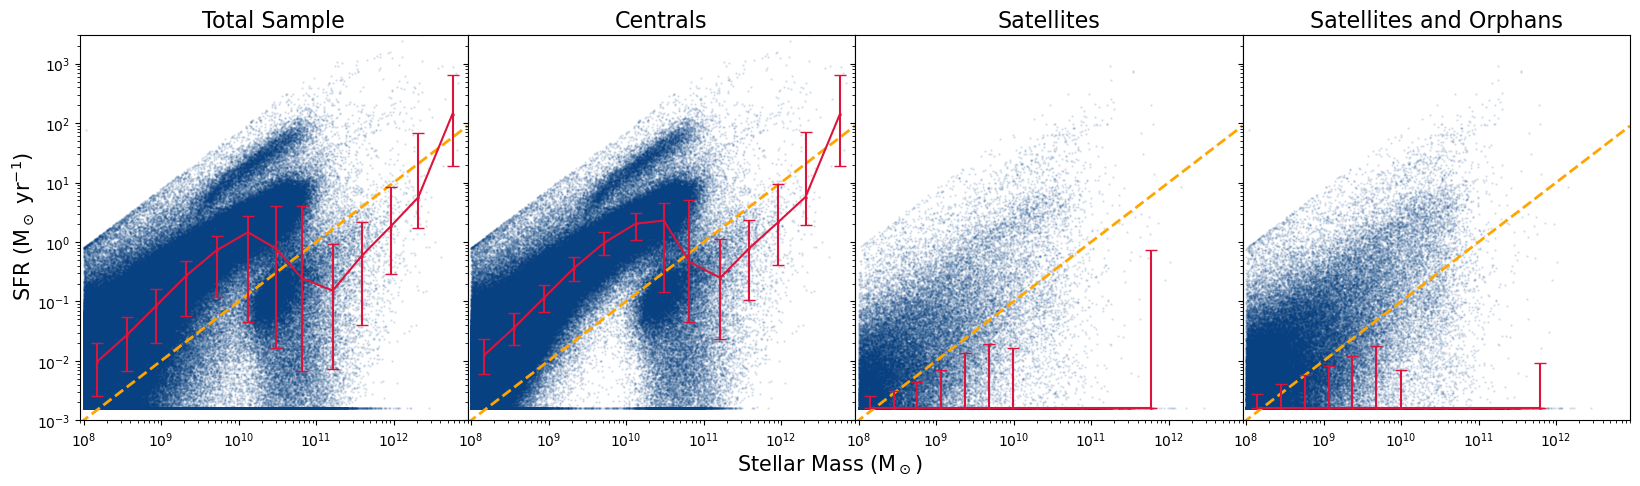

In [16]:
########################################
# Star forming main sequence
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

sfr_threshold = 10**-5

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 10**-3
y_max = 3*10**3
x_min = 9*10**7
x_max = 9*10**12

x = np.logspace(np.log10(x_min), np.log10(x_max), 100)  # Generate stellar mass range
sfr_line = x * 10**-11

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Modify only the 'SFR_all' column in place
    data.loc[data['SFR_all'] < sfr_threshold, 'SFR_all'] = sfr_threshold
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mstar_all'].min())
    highLog = math.log10(data['Mstar_all'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 13
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mstar_all'][(data['Mstar_all'] >= logBins[j]) & (data['Mstar_all'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].scatter(data['Mstar_all'], data['SFR_all'], s=0.8, alpha=0.1, color='#084182')
    axs[i].plot(x, sfr_line, color='orange', linestyle='--', linewidth=2, label='SFR/M* = $10^{-11}$ yr$^{-1}$')
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])
    
    # Bin plotting
    axs[i].scatter(xVals, bin_medians, s=1, color='crimson', marker="^")
    axs[i].plot(xVals, bin_medians, color='crimson', linestyle='-', linewidth=1.5, label='Median Line')
    axs[i].errorbar(xVals, bin_medians, yerr=[bin_medians - p25, p75 - bin_medians], fmt='none', ecolor='crimson', capsize=4)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Stellar Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'SFR (M$_\odot$ yr$^{-1}$)', va='center', rotation='vertical', fontsize=15)

plt.show()

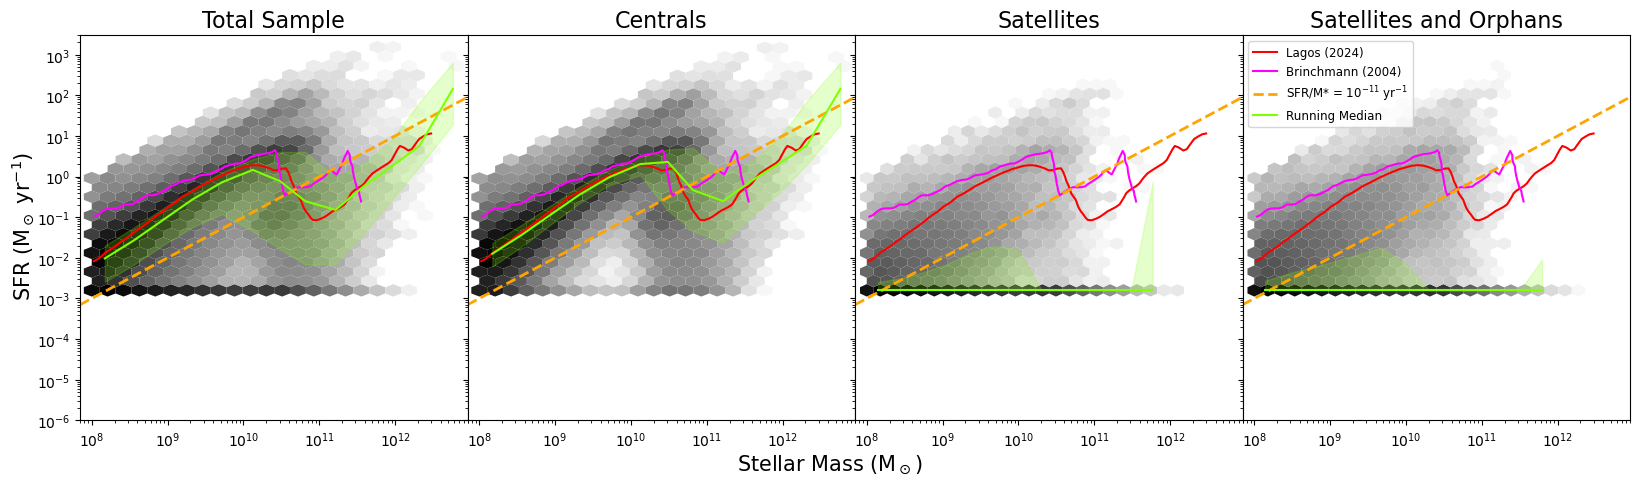

In [20]:
########################################
# Star forming main sequence DENSITY PLOTS
########################################
# List of datasets for easy iteration
datasets = [("Total Sample", shark_csv), 
            ("Centrals", shark_csv_centrals), 
            ("Satellites", shark_csv_satellites), 
            ("Satellites and Orphans", shark_csv_satANDor)]

sfr_threshold = 10**-5

# Create a 1x4 grid of subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
fig.subplots_adjust(wspace=0)

# Set a shared x and y-axis range
y_min = 10**-6
y_max = 3*10**3
x_min = 7*10**7
x_max = 9*10**12

x = np.logspace(np.log10(x_min), np.log10(x_max), 100)  # Generate stellar mass range
sfr_line = x * 10**-11

# Apply this range and ticks to all subplots
for ax in axs:
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())  # Use scalar format for readability

# Loop through each dataset and create a plot
for i, (title, data) in enumerate(datasets):
    # Modify only the 'SFR_all' column in place
    data.loc[data['SFR_all'] < sfr_threshold, 'SFR_all'] = sfr_threshold
    # Calculate min and max log values of Mhalo_host
    lowLog = math.log10(data['Mstar_all'].min())
    highLog = math.log10(data['Mstar_all'].max())

    # Round to the nearest whole number for log binning
    lowLog = round(lowLog, 0)
    highLog = round(highLog, 0)

    # Create log bins
    num_bins = 13
    logBins = np.logspace(lowLog, highLog, num=num_bins + 1)

    # MEDIAN for y-values
    result = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic='median', bins=logBins)
    bin_medians = result.statistic

    # Calculate xVals by finding the median Mhalo_host value within each bin
    xVals = []
    for j in range(len(logBins) - 1):
        # Filter data points within the current bin
        bin_data = data['Mstar_all'][(data['Mstar_all'] >= logBins[j]) & (data['Mstar_all'] < logBins[j+1])]
        if len(bin_data) > 0:
            # Append the median of Mhalo_host values in the bin to xVals
            xVals.append(np.median(bin_data))
        else:
            # If no data points in the bin, append NaN or skip
            xVals.append(np.nan)

    # Convert xVals to a numpy array and remove NaN values (if necessary)
    xVals = np.array(xVals)
    valid_bins = ~np.isnan(xVals)
    xVals = xVals[valid_bins]
    bin_medians = bin_medians[valid_bins]

    # PERCENTILES
    # 25th percentile
    percentile_25 = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic=lambda values: np.percentile(values, 25), bins=logBins)
    p25 = percentile_25.statistic[valid_bins]
    # 75th percentile
    percentile_75 = binned_statistic(data['Mstar_all'], data['SFR_all'], statistic=lambda values: np.percentile(values, 75), bins=logBins)
    p75 = percentile_75.statistic[valid_bins]

    # Plot on the current subplot
    axs[i].hexbin(data['Mstar_all'], data['SFR_all'], gridsize=25, xscale='log', yscale='log',
                       reduce_C_function=np.sum, mincnt=1, bins='log', linewidth=0, cmap='Greys')
    #LAGOS SHARK
    axs[i].plot(SFRline["Column1"], SFRline["Column2"], color='red', linestyle='-', linewidth=1.5, label='Lagos (2024)') 
    #Brinchmann
    axs[i].plot(Brinchmann["Column1"], Brinchmann["Column2"], color='magenta', linestyle='-', linewidth=1.5, label='Brinchmann (2004)') #Brinchmann
    axs[i].plot(x, sfr_line, color='orange', linestyle='--', linewidth=2, label='SFR/M* = $10^{-11}$ yr$^{-1}$')
    
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].set_xlim([x_min, x_max])
    axs[i].set_ylim([y_min, y_max])

    # Bin plotting
    axs[i].plot(xVals, bin_medians, color='chartreuse', linestyle='-', linewidth=1.5, label='Running Median')
    axs[i].fill_between(xVals, p25, p75, color='chartreuse', alpha=0.2)

    # Set titles and remove y-axis labels for intermediate plots
    axs[i].set_title(f'{title}', fontsize=16)

# Add a single x-axis and y-axis label
fig.text(0.5, 0.01, r'Stellar Mass (M$_\odot$)', ha='center', fontsize=15)
fig.text(0.09, 0.5, r'SFR (M$_\odot$ yr$^{-1}$)', va='center', rotation='vertical', fontsize=15)

plt.legend(loc="upper left", fontsize = 8.5)
plt.show()

In [22]:
print((data['SFR_all'] < sfr_threshold).sum())

0
